## Begin of the program
### import statements

#### based on embeddings

In [46]:
!pip install tensorflow scikit-learn pandas numpy pickle5
!pip install matplotlib
!pip install sentence_transformers
!pip install --upgrade transformers tensorflow
!pip install tf-keras

# Import libraries
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
import pickle5 as pickle

import warnings
warnings.filterwarnings('ignore')


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Defaulting to user installation because normal site-packages is not writeable
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Defaulting to user installation because normal site-packages is not writeable
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid 

In [2]:
# Load the dataset
df_orig = pd.read_csv('data_2025_03_15.csv')
print(df_orig.head())

         DATE                        CONVERSATIONID  \
0  2025-03-12  b1b0ce1b-22f4-404d-baa7-13df11078629   
1  2025-03-12  c9c8eaae-d822-4b0f-a0a0-6edc7494b181   
2  2025-03-12  76fd4a88-49f9-4b54-bc4f-b814745c3ce6   
3  2025-03-12  1bc5e581-415c-4673-b1c9-6768900aab1d   
4  2025-03-12  27da2b4a-2187-4321-8cd7-aa4702fd4db2   

                                             SUMMARY TRANSCRIPT_SENTIMENT  \
0  customer intent: The customer is inquiring abo...              Neutral   
1  customer intent: The customer wants to ensure ...             Negative   
2  customer intent: The customer intends to find ...             Positive   
3  customer intent: The customer is seeking infor...              Neutral   
4  customer intent: The customer wants to verify ...             Negative   

  EMPATHY AGENT_PROFANITY MEMBER_PROFANITY PROFESSIONALISM  
0     Yes              No               No             Yes  
1     Yes              No               No             Yes  
2     Yes              

In [3]:
df_orig.describe()

,DATE,CONVERSATIONID,SUMMARY,TRANSCRIPT_SENTIMENT,EMPATHY,AGENT_PROFANITY,MEMBER_PROFANITY,PROFESSIONALISM
count,290972,290972,290972,290972,290972,290972,287765,290972
unique,2,290618,289617,3,2,2,2,2
top,2025-03-12,90e9cf20-812c-43d9-ba89-ea1da4976403,customer intent: Without a particular purpose ...,Positive,Yes,No,No,Yes
freq,156601,3,158,159317,242877,290824,279897,287700


# Exploratory Data Analysis (EDA)

In [4]:
df = df_orig[["SUMMARY", "TRANSCRIPT_SENTIMENT"]]

In [5]:
df['TRANSCRIPT_SENTIMENT'].unique()

array(['Neutral', 'Negative', 'Positive'], dtype=object)

In [6]:
df['TRANSCRIPT_SENTIMENT'].isna().sum()

0

In [7]:
group_counts = df['TRANSCRIPT_SENTIMENT'].value_counts()
print(group_counts)

Positive    159317
Neutral     107301
Negative     24354
Name: TRANSCRIPT_SENTIMENT, dtype: int64


In [8]:
group_freq = df['TRANSCRIPT_SENTIMENT'].value_counts(normalize=True)
print(group_freq)

Positive    0.547534
Neutral     0.368767
Negative    0.083699
Name: TRANSCRIPT_SENTIMENT, dtype: float64


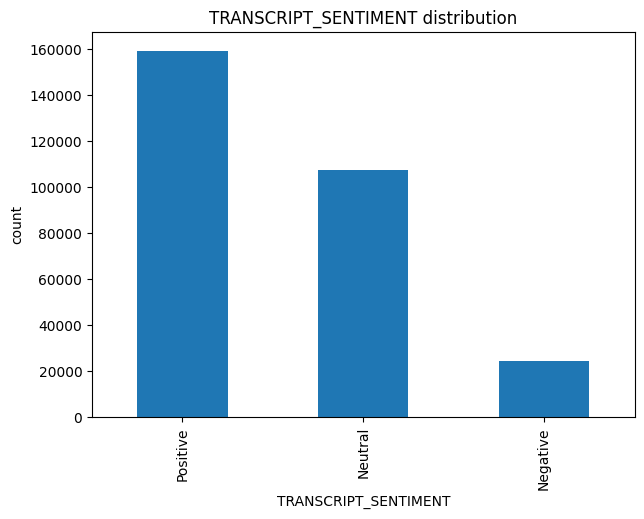

In [9]:
import matplotlib.pyplot as plt

df['TRANSCRIPT_SENTIMENT'].value_counts().plot(kind='bar', figsize=(7,5))
plt.title('TRANSCRIPT_SENTIMENT distribution')
plt.xlabel('TRANSCRIPT_SENTIMENT')
plt.ylabel('count')
plt.show()

<strong> reduce the size of DF so we can do quick testing. 
once done, comment this code.
</strong>

In [10]:
# df1 = df
# df = df1.sample(n=1000, random_state=1)

In [11]:
df['SUMMARY'].iloc[0]

"customer intent: The customer is inquiring about reimbursement for transportation costs incurred by a friend who takes them to medical appointments. agent action:\n* The agent greeted the customer and asked how they could assist.\n* The agent confirmed the customer's inquiry about transportation reimbursement.\n* The agent explained that reimbursement for transportation is not offered unless it is a doctor's order.\n* The agent clarified that the customer's insurance does not cover such reimbursements."

In [12]:
# clean up the text
# using clean-text module. 
%pip install clean-text
import cleantext
cleantext.__version__

from cleantext import clean

def clean_text_custom(text):
    return clean(text,
        fix_unicode=True,               # fix various unicode errors
        to_ascii=True,                  # transliterate to closest ASCII representation
        lower=True,                     # lowercase text
        no_line_breaks=True,           # fully strip line breaks as opposed to only normalizing them
        no_urls=True,                  # replace all URLs with a special token
        no_emails=True,                # replace all email addresses with a special token
        no_phone_numbers=True,         # replace all phone numbers with a special token
        no_numbers=True,               # replace all numbers with a special token
        no_digits=True,                # replace all digits with a special token
        no_currency_symbols=True,      # replace all currency symbols with a special token
        no_punct=True,                 # remove punctuations
        replace_with_punct="",          # instead of removing punctuations you may replace them
        replace_with_url="<URL>",
        replace_with_email="<EMAIL>",
        replace_with_phone_number="<PHONE>",
        replace_with_number="<NUMBER>",
        replace_with_digit="0",
        replace_with_currency_symbol="<CUR>",
        lang="en"                       # 'en' for English
    )
    
df["SUMMARY"] = df["SUMMARY"].apply(clean_text_custom)

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.


In [13]:
df['SUMMARY'].iloc[0]

'customer intent the customer is inquiring about reimbursement for transportation costs incurred by a friend who takes them to medical appointments agent action the agent greeted the customer and asked how they could assist the agent confirmed the customers inquiry about transportation reimbursement the agent explained that reimbursement for transportation is not offered unless it is a doctors order the agent clarified that the customers insurance does not cover such reimbursements'

# Model building
##  preparing embeddings

In [14]:

from sentence_transformers import SentenceTransformer
warnings.filterwarnings('ignore')

# Example model and DataFrame (modify for your use case)
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')


# Encode text into embeddings (shape: [num_rows, embedding_dim])
embeddings = np.array(model.encode(df["SUMMARY"].tolist()))

print(embeddings.shape)
df["EMBEDDINGS"] = embeddings.tolist()

# now save the dataframe in zip-compressed pickle file

df.to_pickle(
    "df_with_embeddings.pkl.zip", 
    compression="zip"
)
print("Saved df_no_japanese in zip-compressed pickle format.")

(290972, 384)
Saved df_no_japanese in zip-compressed pickle format.


In [15]:
df.sample(4)

,SUMMARY,TRANSCRIPT_SENTIMENT,EMBEDDINGS
132603,customer intent the customer is checking the s...,Positive,"[-0.10847028344869614, 0.09188905358314514, -0..."
40091,customer intent to verify eligibility informat...,Neutral,"[-0.07871349900960922, 0.11425510048866272, 0...."
116244,customer intent the customer is trying to find...,Positive,"[-0.0654219314455986, 0.030085593461990356, -0..."
50521,customer intent the customer wants to verify t...,Positive,"[-0.07022859156131744, 0.09063606709241867, -0..."


In [47]:
# now load the pickle file and work on it. 

df_loaded = pd.read_pickle("df_with_embeddings.pkl.zip")
df_loaded.sample(4)

,SUMMARY,TRANSCRIPT_SENTIMENT,EMBEDDINGS
88982,customer intent the customer intends to resolv...,Neutral,"[-0.08034465461969376, 0.09002897143363953, -0..."
65435,customer intent the customer intends to verify...,Neutral,"[-0.05040843039751053, 0.051747821271419525, -..."
88068,customer intent the customer wants to pay thei...,Neutral,"[-0.04749929532408714, 0.06721492856740952, -0..."
59751,customer intent the customer wants to understa...,Positive,"[-0.0014742808416485786, 0.13571126759052277, ..."


In [48]:
df_loaded.columns

Index(['SUMMARY', 'TRANSCRIPT_SENTIMENT', 'EMBEDDINGS'], dtype='object')

In [49]:
df_loaded["TRANSCRIPT_SENTIMENT"].unique()

array(['Neutral', 'Negative', 'Positive'], dtype=object)

In [50]:
# Ensure embeddings and category labels are in the DataFrame

X = np.array(df_loaded["EMBEDDINGS"].tolist())  # Convert embeddings list to array
y = df_loaded["TRANSCRIPT_SENTIMENT"]  # 'TRANSCRIPT_SENTIMENT' column has target labels

In [51]:
# import few more statements

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


In [52]:
#converting to numeric class id
#Encode target labels
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_loaded["TRANSCRIPT_SENTIMENT"])  # y has target labels (TRANSCRIPT_SENTIMENT)

In [53]:
# Split the data into training and validation sets.

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.20, random_state=42, stratify=y_encoded

)

In [54]:
# import few more packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization
from tensorflow.keras.regularizers import l2


In [64]:
# get number of classes from target train data; we should get 3
num_classes = len(np.unique(y_train))
print("Number of classes:", num_classes)

classes_train = np.unique(y_train, return_counts=True)[0]
counts_train = np.unique(y_train, return_counts=True)[1]

# print("classes_train:", classes_train)
# print("counts_train:", counts_train)


class_counts_train = {classes_train[i]:counts_train[i] for i in range(len(classes_train))}
print("class_counts_train:", class_counts_train)

Y_weights = {}
X_class_ratios = {}
Y_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
for label, enc in Y_map.items():
    Y_weights[enc] = round(np.log(len(X_train)/class_counts_train[enc]), 2)
    X_class_ratios[enc] = round(class_counts_train[enc]/len(X_train))

print("training start")

# Define the Sequential model
classifier = Sequential()
classifier.add(Dense(1024, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(1e-4)))
classifier.add(BatchNormalization())
classifier.add(Dropout(0.5))

classifier.add(Dense(512, activation='relu', kernel_regularizer=l2(1e-4)))
classifier.add(BatchNormalization())
classifier.add(Dropout(0.5))

classifier.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
classifier.add(BatchNormalization())
classifier.add(Dropout(0.5))

## for last one,  matching the number of classes with what we predicting and using 'softmax' for activation
classifier.add(Dense(num_classes, activation='softmax'))

Number of classes: 3
class_counts_train: {0: 19483, 1: 85841, 2: 127453}
training start


In [65]:
label_encoder.classes_

array(['Negative', 'Neutral', 'Positive'], dtype=object)

In [66]:
label_encoder.transform(label_encoder.classes_)

array([0, 1, 2])

In [67]:
z = zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))
print(dict(z))

{'Negative': 0, 'Neutral': 1, 'Positive': 2}


In [68]:
# check the shape of X and y to ensure they are aligned correctly
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (290972, 384), y shape: (290972,)


In [69]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0005, epsilon=1e-06)
classifier.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy']) # sparse_categorical_crossentropy

In [70]:
from tensorflow.keras.callbacks import EarlyStopping

# Create an early stopping callback that monitors the validation loss.
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
# early stopping is used to prevent overfitting. 
# monitor the model’s performance on a separate validation set during training and to stop the 
# training process when the performance stops improving

history_accuracy = classifier.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=200, 
    validation_data=(X_test, y_test), 
    shuffle=True, 
    class_weight=Y_weights, 
    verbose=2,
    callbacks=[early_stopping]
)


Epoch 1/50
1164/1164 - 67s - loss: 1.0408 - accuracy: 0.5856 - val_loss: 0.9326 - val_accuracy: 0.6294 - 67s/epoch - 58ms/step
Epoch 2/50
1164/1164 - 64s - loss: 0.8878 - accuracy: 0.6400 - val_loss: 0.8810 - val_accuracy: 0.6505 - 64s/epoch - 55ms/step
Epoch 3/50
1164/1164 - 64s - loss: 0.8530 - accuracy: 0.6484 - val_loss: 0.8312 - val_accuracy: 0.6638 - 64s/epoch - 55ms/step
Epoch 4/50
1164/1164 - 64s - loss: 0.8249 - accuracy: 0.6540 - val_loss: 0.8181 - val_accuracy: 0.6641 - 64s/epoch - 55ms/step
Epoch 5/50
1164/1164 - 64s - loss: 0.8030 - accuracy: 0.6562 - val_loss: 0.8798 - val_accuracy: 0.6230 - 64s/epoch - 55ms/step
Epoch 6/50
1164/1164 - 64s - loss: 0.7879 - accuracy: 0.6582 - val_loss: 0.7604 - val_accuracy: 0.6789 - 64s/epoch - 55ms/step
Epoch 7/50
1164/1164 - 64s - loss: 0.7767 - accuracy: 0.6587 - val_loss: 0.8184 - val_accuracy: 0.6458 - 64s/epoch - 55ms/step
Epoch 8/50
1164/1164 - 64s - loss: 0.7712 - accuracy: 0.6609 - val_loss: 0.8552 - val_accuracy: 0.6201 - 64s/ep

In [71]:
# printing history values

for epoch in range(len(history_accuracy.history['loss'])):
    print(f"Epoch {(epoch+1):2.0f}: accuracy = {history_accuracy.history['accuracy'][epoch]:.4f}, "
          f"loss = {history_accuracy.history['loss'][epoch]:.4f}, "
          f"val_accuracy = {history_accuracy.history['val_accuracy'][epoch]:.4f}, "
          f"val_loss = {history_accuracy.history['val_loss'][epoch]:.4f}")

Epoch  1: accuracy = 0.5856, loss = 1.0408, val_accuracy = 0.6294, val_loss = 0.9326
Epoch  2: accuracy = 0.6400, loss = 0.8878, val_accuracy = 0.6505, val_loss = 0.8810
Epoch  3: accuracy = 0.6484, loss = 0.8530, val_accuracy = 0.6638, val_loss = 0.8312
Epoch  4: accuracy = 0.6540, loss = 0.8249, val_accuracy = 0.6641, val_loss = 0.8181
Epoch  5: accuracy = 0.6562, loss = 0.8030, val_accuracy = 0.6230, val_loss = 0.8798
Epoch  6: accuracy = 0.6582, loss = 0.7879, val_accuracy = 0.6789, val_loss = 0.7604
Epoch  7: accuracy = 0.6587, loss = 0.7767, val_accuracy = 0.6458, val_loss = 0.8184
Epoch  8: accuracy = 0.6609, loss = 0.7712, val_accuracy = 0.6201, val_loss = 0.8552
Epoch  9: accuracy = 0.6626, loss = 0.7656, val_accuracy = 0.6723, val_loss = 0.7645


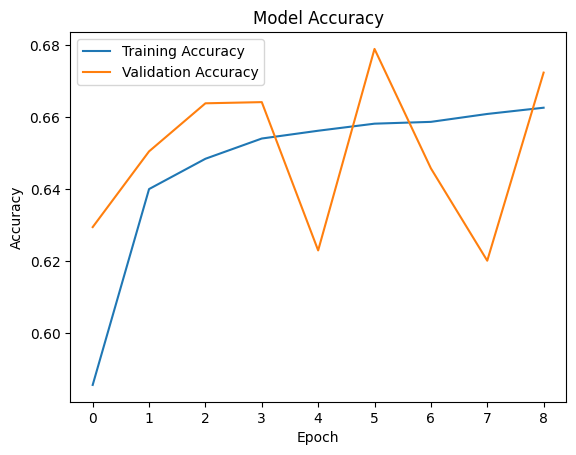

In [72]:
# draw a graph of accuracy curve from history data object
plt.plot(history_accuracy.history['accuracy'], label='Training Accuracy')
plt.plot(history_accuracy.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

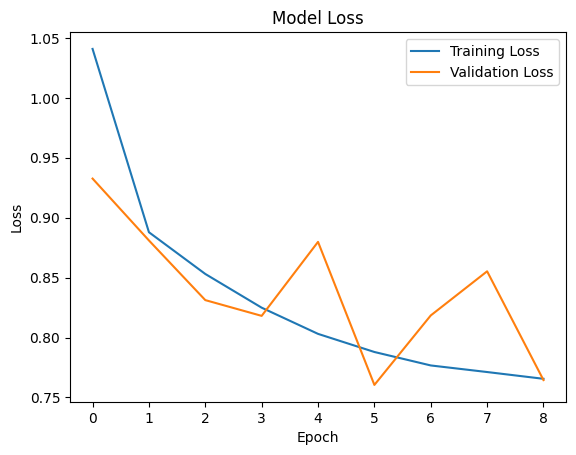

In [73]:
# draw Loss curve from history 

plt.plot(history_accuracy.history['loss'], label='Training Loss')
plt.plot(history_accuracy.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [74]:
# now evaluate the model
loss, accuracy = classifier.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

1819/1819 [==============================] - 7s 4ms/step - loss: 0.7604 - accuracy: 0.6789
Test Loss: 0.7604, Test Accuracy: 0.6789


In [75]:
# make few predictions on the test set
pred_probs = classifier.predict(X_test)
pred_indices = np.argmax(pred_probs, axis=1)
pred_labels = label_encoder.inverse_transform(pred_indices)

import random
# Compare a few predictions with the true labels
# out of 1000 limited data we took, 20% is train data. 
# so, randomly pick 
for i in random.sample(range(1,200), 5):
    true_label = label_encoder.inverse_transform([y_test[i]])[0]
    print(f"Sample {i}: Predicted: {pred_labels[i]}, True: {true_label}")

1819/1819 [==============================] - 6s 3ms/step
Sample 78: Predicted: Negative, True: Neutral
Sample 27: Predicted: Positive, True: Neutral
Sample 67: Predicted: Neutral, True: Neutral
Sample 138: Predicted: Neutral, True: Negative
Sample 89: Predicted: Positive, True: Positive


In [76]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# Alternatively, compute individual metrics (weighted averages for multi-class)
precision = precision_score(y_test, pred_indices, average='weighted')
recall = recall_score(y_test, pred_indices, average='weighted')
f1 = f1_score(y_test, pred_indices, average='weighted')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.6917
Recall: 0.6789
F1 Score: 0.6811


In [77]:
print("Shape of y_encoded:", y_encoded.shape)
print("Shape of pred_indices:", pred_indices.shape)

Shape of y_encoded: (290972,)
Shape of pred_indices: (58195,)


## ROC AUC score and Confusion matrix

In [78]:

from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.preprocessing import label_binarize

# For multi-class ROC AUC and PR AUC, binarize the labels.
# Here we assume the classes are 0, 1, ..., num_classes-1.
y_test_binarized = label_binarize(y_test, classes=np.arange(num_classes))

# Compute ROC AUC using the One-vs-Rest (OvR) strategy, using macro-average.

roc_auc = roc_auc_score(y_test_binarized, pred_probs, average='macro', multi_class='ovr')
print(f"ROC AUC Score: {roc_auc:.4f}")

# Compute PR AUC (average precision score) for multi-class (macro-average).
# helpful for highly imbalanced datasets, as it focuses on the performance of the positive class.
pr_auc = average_precision_score(y_test_binarized, pred_probs, average='macro')
print(f"PR AUC Score: {pr_auc:.4f}")

ROC AUC Score: 0.8214
PR AUC Score: 0.6437


TODO
ROC AUC Score 0.6559 is pretty low. this may be due to very small sample I picked. 
re-write this again when model is run with all ~ 300K rows. 
clearly with full data score imporved. 

In [79]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


# Make predictions on the test set
pred_probabilities = classifier.predict(X_test)

# For multi-class classification, convert probabilities to class indices
pred_indices = np.argmax(pred_probabilities, axis=1)

# Compute per-class metrics using y_test (not y_encoded)
precision = precision_score(y_test, pred_indices, average=None)
recall = recall_score(y_test, pred_indices, average=None)
f1 = f1_score(y_test, pred_indices, average=None)

# Print per-class metrics with class names
for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
    class_name = label_encoder.inverse_transform([i])[0]
    print(f"{class_name}: Precision: {p:.4f}, Recall: {r:.4f}, F1 Score: {f:.4f}")

# Alternatively, print a full classification report
print("\nFull Classification Report:")
print(classification_report(y_test, pred_indices, target_names=label_encoder.classes_))

1819/1819 [==============================] - 6s 3ms/step
Negative: Precision: 0.4173, Recall: 0.3463, F1 Score: 0.3785
Neutral: Precision: 0.5791, Recall: 0.7040, F1 Score: 0.6354
Positive: Precision: 0.8095, Recall: 0.7129, F1 Score: 0.7581

Full Classification Report:
              precision    recall  f1-score   support

    Negative       0.42      0.35      0.38      4871
     Neutral       0.58      0.70      0.64     21460
    Positive       0.81      0.71      0.76     31864

    accuracy                           0.68     58195
   macro avg       0.60      0.59      0.59     58195
weighted avg       0.69      0.68      0.68     58195



In [80]:

from sklearn.metrics import confusion_matrix

# Assume y_test and pred_indices are defined and have the same length.
cm = confusion_matrix(y_test, pred_indices)
total_samples = cm.sum()
per_class_accuracy = []

for i in range(cm.shape[0]):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = total_samples - (TP + FP + FN)
    class_accuracy = (TP + TN) / total_samples
    per_class_accuracy.append(class_accuracy)

# Print per-class accuracy with class names
for i, acc in enumerate(per_class_accuracy):
    class_name = label_encoder.inverse_transform([i])[0]
    print(f"{class_name}: Accuracy: {acc:.4f}")


Negative: Accuracy: 0.9048
Neutral: Accuracy: 0.7021
Positive: Accuracy: 0.7509


Classification Report for Top 5 Classes:
              precision    recall  f1-score   support

    Positive       0.81      0.71      0.76     31864
     Neutral       0.58      0.70      0.64     21460
    Negative       0.42      0.35      0.38      4871

    accuracy                           0.68     58195
   macro avg       0.60      0.59      0.59     58195
weighted avg       0.69      0.68      0.68     58195



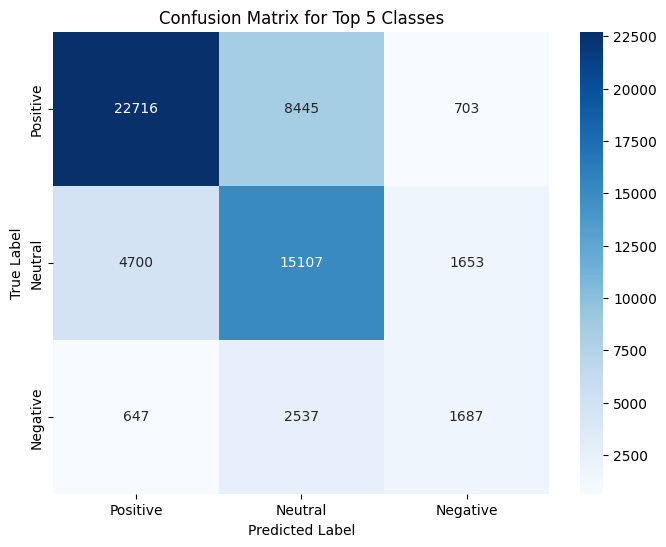

In [90]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Assume y_test and pred_indices are defined (pred_indices obtained from model.predict)
# Also assume label_encoder is defined so we can convert encoded labels to their names.

# 1. Count the frequency of each class in y_test
unique_classes, counts = np.unique(y_test, return_counts=True)

# 2. Identify the top classes (by count)
sorted_idx = np.argsort(counts)[::-1]  # sort indices descending by frequency
top5_classes = unique_classes[sorted_idx][:3]

# 3. Filter y_test and pred_indices to include only samples of these top 5 classes
mask = np.isin(y_test, top5_classes)
y_test_top5 = y_test[mask]
pred_indices_top5 = pred_indices[mask]

# 4. Compute the confusion matrix for the top 5 classes
cm_top5 = confusion_matrix(y_test_top5, pred_indices_top5, labels=top5_classes)

# Convert the class indices to their names for better visualization
class_names_top5 = label_encoder.inverse_transform(top5_classes)

# Optional: print a classification report for the top 5 classes
print("Classification Report for Top 5 Classes:")
print(classification_report(y_test_top5, pred_indices_top5, target_names=class_names_top5, labels=top5_classes))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_top5, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names_top5,
            yticklabels=class_names_top5)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Top 5 Classes')
plt.show()

1819/1819 [==============================] - 6s 3ms/step


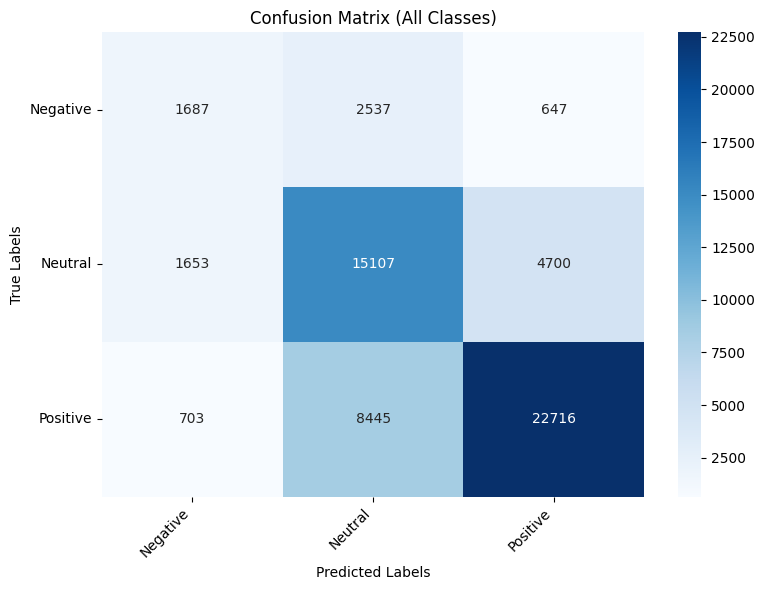

In [91]:
# Define class names from label_encoder
class_names = label_encoder.classes_

# Generate predictions
y_pred_proba = classifier.predict(X_test)
y_pred_indices = np.argmax(y_pred_proba, axis=1)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_indices)

# Plot confusion matrix clearly
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    xticklabels=class_names, 
    yticklabels=class_names
)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (All Classes)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [92]:
# confusion matrix data validation 

import numpy as np
import pandas as pd

# 1. Get predictions
pred_proba = classifier.predict(X_test)
pred_indices = np.argmax(pred_proba, axis=1)

# 2. Identify top 5 classes
unique_classes, counts = np.unique(y_test, return_counts=True)
sorted_idx = np.argsort(counts)[::-1]
top5_classes = unique_classes[sorted_idx][:5]

train_indices, test_indices = train_test_split(
    df_loaded.index, 
    test_size=0.20, 
    random_state=42, 
    stratify=y_encoded
)

df_test = df_loaded.loc[test_indices].copy()
df_test['true_label']  = y_test
df_test['pred_label']  = pred_indices

df_test['true_label_name'] = label_encoder.inverse_transform(df_test['true_label'])
df_test['pred_label_name'] = label_encoder.inverse_transform(df_test['pred_label'])

# Keep only samples that belong to the top 5 classes
mask_top5 = df_test['true_label'].isin(top5_classes)

# Keep only misclassified samples (where predicted != actual)
mask_misclassified = df_test['true_label'] != df_test['pred_label']

# Combine both masks
df_misclassified_top5 = df_test[mask_top5 & mask_misclassified]

# df_test is a subset of the original df_no_japanese plus columns for labels
df_misclassified_top5 = df_test[mask_top5 & mask_misclassified].merge(
    df_loaded[['SUMMARY']],  # or whichever columns
    left_index=True,  # if df_test kept the same index as the original
    right_index=True
)


1819/1819 [==============================] - 6s 3ms/step


In [93]:
df_misclassified_top5.head(3)

,SUMMARY_x,TRANSCRIPT_SENTIMENT,EMBEDDINGS,true_label,pred_label,true_label_name,pred_label_name,SUMMARY_y
97449,customer intent the customer wants to understa...,Positive,"[0.01646520011126995, 0.08973946422338486, 0.0...",2,1,Positive,Neutral,customer intent the customer wants to understa...
197629,customer intent the customer is seeking the st...,Neutral,"[-0.11897347122430801, 0.04218515008687973, -0...",1,2,Neutral,Positive,customer intent the customer is seeking the st...
169577,customer intent the customer is seeking inform...,Positive,"[-0.0630723163485527, 0.06704790890216827, -0....",2,1,Positive,Neutral,customer intent the customer is seeking inform...


In [94]:
num_rows = df_misclassified_top5.shape[0]
print(f"Number of rows: {num_rows}")

Number of rows: 18685


In [95]:
df_misclassified_top5.columns

Index(['SUMMARY_x', 'TRANSCRIPT_SENTIMENT', 'EMBEDDINGS', 'true_label',
       'pred_label', 'true_label_name', 'pred_label_name', 'SUMMARY_y'],
      dtype='object')

In [96]:
mask = (
    (df_misclassified_top5["true_label_name"] == "Positive") &
    (df_misclassified_top5["pred_label_name"] == "Neutral")
)
df_filtered_cs_c = df_misclassified_top5[mask]

# Print just those filtered rows (all columns)
print(df_filtered_cs_c)
#df_filtered_cs_t_500 = print(df_filtered_cs_t.iloc[:500])


                                                SUMMARY_x  \
97449   customer intent the customer wants to understa...   
169577  customer intent the customer is seeking inform...   
103277  customer intent the customer wants to verify t...   
255483  customer intent the customer is calling to inq...   
174468  customer intent the customer wants to log into...   
...                                                   ...   
17183   customer intent the customer is seeking assist...   
10178   customer intent the customer is seeking assist...   
91527   customer intent the customer intends to assist...   
281683  customer intent the customer is seeking clarif...   
244476  customer intent the customer wants to know how...   

       TRANSCRIPT_SENTIMENT  \
97449              Positive   
169577             Positive   
103277             Positive   
255483             Positive   
174468             Positive   
...                     ...   
17183              Positive   
10178              

# Compare with other models( LogisticRegression, Random Forest, GB)

In [97]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Create and fit logistic regression with balanced classes
log_reg = LogisticRegression(class_weight='balanced', max_iter=500, random_state=42)
log_reg.fit(X_train, y_train)

# Calculate accuracy
train_accuracy = log_reg.score(X_train, y_train)
test_accuracy = log_reg.score(X_test, y_test)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")


Training Accuracy: 0.6246
Testing Accuracy: 0.6190


In [98]:
from sklearn.linear_model import LogisticRegression# 1. LOGISTIC REGRESSION

lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

# Calculate "overall" precision, recall, and F1
# 'macro' averages metrics equally across classes,
# 'weighted' averages by class support (size).
lr_precision = precision_score(y_test, lr_preds, average='weighted')
lr_recall = recall_score(y_test, lr_preds, average='weighted')
lr_f1 = f1_score(y_test, lr_preds, average='weighted')

print("=== Logistic Regression (Overall Metrics) ===")
print(f"Precision (weighted): {lr_precision:.3f}")
print(f"Recall (weighted):    {lr_recall:.3f}")
print(f"F1-score (weighted):  {lr_f1:.3f}")

# (Optional) Detailed metrics per class
print("\nLogistic Regression classification report:")
print(classification_report(y_test, lr_preds))

=== Logistic Regression (Overall Metrics) ===
Precision (weighted): 0.685
Recall (weighted):    0.619
F1-score (weighted):  0.639

Logistic Regression classification report:
              precision    recall  f1-score   support

           0       0.24      0.66      0.36      4871
           1       0.62      0.49      0.55     21460
           2       0.80      0.70      0.74     31864

    accuracy                           0.62     58195
   macro avg       0.55      0.62      0.55     58195
weighted avg       0.69      0.62      0.64     58195



In [104]:
from sklearn.ensemble import RandomForestClassifier

# Define and train Random Forest with balanced class weights
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

# Predictions
train_preds_rf = rf.predict(X_train)
test_preds_rf = rf.predict(X_test)

# Accuracy calculation
train_accuracy_rf = rf.score(X_train, y_train)
test_accuracy = rf.score(X_test, y_test)

# Print accuracies clearly
print(f"Random Forest Training Accuracy: {train_accuracy:.4f}")
print(f"Random Forest Testing Accuracy: {test_accuracy:.4f}")


Random Forest Training Accuracy: 0.6738
Random Forest Testing Accuracy: 0.6572


In [101]:
# 2. RANDOM FOREST
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

rf_precision = precision_score(y_test, rf_preds, average='weighted')
rf_recall = recall_score(y_test, rf_preds, average='weighted')
rf_f1 = f1_score(y_test, rf_preds, average='weighted')

print("=== Random Forest (Overall Metrics) ===")
print(f"Precision (weighted): {rf_precision:.3f}")
print(f"Recall (weighted):    {rf_recall:.3f}")
print(f"F1-score (weighted):  {rf_f1:.3f}")

# (Optional) Detailed metrics per class
print("\nRandom Forest classification report:")
print(classification_report(y_test, rf_preds))

=== Random Forest (Overall Metrics) ===
Precision (weighted): 0.659
Recall (weighted):    0.657
F1-score (weighted):  0.624

Random Forest classification report:
              precision    recall  f1-score   support

           0       0.76      0.04      0.08      4871
           1       0.61      0.50      0.55     21460
           2       0.68      0.86      0.76     31864

    accuracy                           0.66     58195
   macro avg       0.68      0.47      0.46     58195
weighted avg       0.66      0.66      0.62     58195



In [102]:
# GB classifier 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

# Gradient Boosting classifier
gb = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

# Fit model
gb.fit(X_train, y_train)

# Predictions for both train and test
y_train_pred = gb.predict(X_train)
y_test_pred = gb.predict(X_test)

# Metrics calculation
metrics = lambda y_true, y_pred: {
    "Accuracy": round(np.mean(y_true = y_train if y_train_pred is y_train_pred else y_test) == y_train_pred, 3),
    "Precision": precision_score(y_true, y_train_pred if y_true is y_train else y_test_pred, average='weighted'),
    "Recall": recall_score(y_train if 'train' in locals() else y_test, y_train_pred if 'train' in locals() else y_test_pred, average='weighted'),
    "F1-score": f1_score(y_true, y_train_pred if y_true is y_train else y_test_pred, average='weighted')
}

# Training metrics
train_accuracy = gb.score(X_train, y_train)
train_precision = precision_score(y_train, y_train_pred, average='weighted')
train_recall = recall_score(y_train, y_train_pred, average='weighted')
train_f1 = f1_score(y_train, y_train_pred, average='weighted')

# Testing metrics
test_accuracy = gb.score(X_test, y_test)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

# Printing results clearly
print("=== Gradient Boosting: TRAIN Metrics ===")
print(f"Accuracy : {gb.score(X_train, y_train):.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall:    {train_recall:.4f}")
print(f"F1-score:  {train_f1:.4f}")

print("\n=== Gradient Boosting: (TEST Metrics) ===")
print(f"Accuracy:  {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall:    {test_recall:.4f}")
print(f"F1-score:  {test_f1:.4f}")


=== Gradient Boosting: TRAIN Metrics ===
Accuracy : 0.6738
Precision: 0.6720
Recall:    0.6738
F1-score:  0.6466

=== Gradient Boosting: (TEST Metrics) ===
Accuracy:  0.6640
Precision: 0.6575
Recall:    0.6640
F1-score:  0.6372


In [103]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
import pandas as pd
import numpy as np

# Train Gradient Boosting Classifier
gb = GradientBoostingClassifier(
    n_estimators=30, learning_rate=0.2, max_depth=2, random_state=42
)
gb.fit(X_train, y_train)  # Ensure X_train and y_train are defined before this line

# Predict on test data
y_test_pred = gb.predict(X_test)

# Metrics per class
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_test_pred)

# Creating DataFrame for clear viewing
metrics_df = pd.DataFrame({
    "Class": label_encoder.inverse_transform(np.unique(y_test)),
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1,
    "Support": support
})

# Sort by 'Support' clearly
metrics_df_sorted = metrics_df.sort_values(by='Support', ascending=False).reset_index(drop=True)

# Print the sorted metrics DataFrame
#print("\n=== Gradient Boosting Metrics Per Class ===")
#print(metrics_df.sort_values(by='Support', ascending=False).reset_index(drop=True))

# Overall accuracy clearly
accuracy = accuracy_score(y_test, y_test_pred)
print(f"\nOverall Test Accuracy: {accuracy:.4f}")

# Optional: Detailed classification report clearly displayed
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))



Overall Test Accuracy: 0.6490

Detailed Classification Report:
              precision    recall  f1-score   support

    Negative       0.68      0.03      0.06      4871
     Neutral       0.59      0.51      0.54     21460
    Positive       0.68      0.84      0.75     31864

    accuracy                           0.65     58195
   macro avg       0.65      0.46      0.45     58195
weighted avg       0.64      0.65      0.62     58195



# saving model 

In [ ]:
#save the model
# Save the trained model in HDF5 format
classifier.save("classifier_model.h5")
print("✅ Model saved successfully as classifier_model.h5")

classifier.save("classifier_model.keras")
print("✅ Model saved successfully in .keras format!")


# load model and test with data

In [6]:
# %pip install tensorflow #reload the model from saved file

from tensorflow.keras.models import load_model

#reload h5 saved format
# loaded_model = load_model("classifier_model.h5")
# loaded_model.summary()

loaded_model = load_model("classifier_model.keras")
loaded_model.summary()


2025-04-18 10:48:47.437989: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-04-18 10:48:47.439116: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2025-04-18 10:48:47.439175: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sqapod-11042024-0): /proc/driver/nvidia/version does not exist
2025-04-18 10:48:47.439482: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 1024)              394240    
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 1024)              1049600   
                                                                 
 batch_normalization_2 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 1024)             

In [ ]:
# Making Predictions
# X_test should be a NumPy array or tf.Tensor matching the input shape
predictions = loaded_model.predict(X_test)

# For classification, you might do:
predicted_classes = (predictions > 0.5).astype("int32")
